# Introducción a los métodos de Monte-Carlo con Python

*Esta notebook fue creadO originalmente como un blog post por [Raúl E. López Briega](http://relopezbriega.com.ar/) en [Matemáticas, análisis de datos y python](http://relopezbriega.github.io). El contenido esta bajo la licencia BSD.*

Lea el [siguiente artículo](https://www.datacamp.com/community/tutorials/markov-chains-python-tutorial) previo a la clase.

## Métodos de Monte-Carlo via cadenas de Markov 

El desarrollo de los [métodos de Monte-Carlo via cadenas de Markov](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo), o [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) por sus siglas en inglés, es sin duda uno de los mayores avances en el enfoque computacional de la [estadística](http://relopezbriega.github.io/tag/estadistica.html). Muchos de los problemas que son intratables utilizando un enfoque *analítico* a menudo pueden ser resueltos utilizando alguna forma de [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo), incluso aunque se trate de problemas en varias [dimensiones](https://es.wikipedia.org/wiki/Dimensi%C3%B3n). 
Las técnicas [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) se aplican para resolver problemas de [integración](https://es.wikipedia.org/wiki/Integraci%C3%B3n) y <a href="https://es.wikipedia.org/wiki/Optimizaci%C3%B3n_(matem%C3%A1tica)">optimización</a> en grandes [espacios dimensionales](https://es.wikipedia.org/wiki/Espacio_de_Hilbert). Estos dos tipos de problemas desempeñan un papel fundamental en [machine learning](http://relopezbriega.github.io/category/machine-learning.html), [física](https://es.wikipedia.org/wiki/F%C3%ADsica), [estadística](http://relopezbriega.github.io/tag/estadistica.html), [econometría](https://es.wikipedia.org/wiki/Econometr%C3%ADa) y el [análisis de decisiones](https://es.wikipedia.org/wiki/An%C3%A1lisis_de_decisi%C3%B3n).

### ¿Qué es una cadena de Markov?

Una [cadena de Markov](https://es.wikipedia.org/wiki/Cadena_de_M%C3%A1rkov) es un objeto matemático que consiste en una secuencia de estados y un conjunto de [probabilidades](http://relopezbriega.github.io/tag/probabilidad.html) que describen las *transiciones entre esos estados*. La característica principal que tiene esta cadena es que la probabilidad de moverse a otros estados **depende solamente del estado actual**. Dada una cadena, se puede realizar una [caminata aleatoria](https://es.wikipedia.org/wiki/Camino_aleatorio) eligiendo un punto de partida y moviéndose a otros estados siguiendo las *[probabilidades](http://relopezbriega.github.io/tag/probabilidad.html) de transición*. Si de alguna manera encontramos una [cadena de Markov](https://es.wikipedia.org/wiki/Cadena_de_M%C3%A1rkov) con *transiciones proporcionales* a la distribución que queremos probar, el <a href="https://es.wikipedia.org/wiki/Muestreo_(estad%C3%ADstica)">muestreo</a> se convierte simplemente en una cuestión de moverse entre los estados de esta cadena.

#### Caminata aleatoria en un grafo

Una [cadena de Markov](https://es.wikipedia.org/wiki/Cadena_de_M%C3%A1rkov) puede ser ilustrada con el siguiente [grafo](https://es.wikipedia.org/wiki/Grafo), el cual representa una [cadena de Markov](https://es.wikipedia.org/wiki/Cadena_de_M%C3%A1rkov) de cuatro estados.

<img alt="Cadena de Markov" title="Cadena de Markov" src="http://relopezbriega.github.io/images/MC.png" >

Los estados de la cadena se representan como los nodos del [grafo](https://es.wikipedia.org/wiki/Grafo), una <a href="https://es.wikipedia.org/wiki/Arista_(teor%C3%ADa_de_grafos)" >arista</a> de dirección se extiende de un nodo $x$ hacia otro nodo $y$ si la transición de $x$ hacia $y$ es posible en una iteración. Cada una de estas <a href="https://es.wikipedia.org/wiki/Arista_(teor%C3%ADa_de_grafos)" >aristas</a> de dirección tienen una [probabilidad](http://relopezbriega.github.io/tag/probabilidad.html) asociada $P_{xy}$; esta es la [probabilidad](http://relopezbriega.github.io/tag/probabilidad.html) de que el nodo sea elegido en la siguiente iteración cuando la cadena se encuentra en el estado $x$. La cadena comienza en algún estado, digamos $X_0$, que puede ser elegido en forma [aleatoria](https://es.wikipedia.org/wiki/Aleatoriedad) de acuerdo con una [distribución](http://relopezbriega.github.io/blog/2016/06/29/distribuciones-de-probabilidad-con-python/) inicial o simplemente asignado en forma arbitraria. Desde allí, la cadena se mueve de un estado a otro en cada iteración según las [probabilidades](http://relopezbriega.github.io/tag/probabilidad.html) de transición del nodo vecino.

#### Representación matricial

Como alternativa a la representación en forma de [grafo](https://es.wikipedia.org/wiki/Grafo), la cadena antes descripta también puede ser representada por una <a href="http://es.wikipedia.org/wiki/Matriz_(matem%C3%A1ticas)" >matriz</a> $P = (p_{xy})$ de las [probabilidades](http://relopezbriega.github.io/tag/probabilidad.html) $p_{xy}$ de transición de un estado $x$ a un estado $y$ en una iteración de la cadena. Esta <a href="http://es.wikipedia.org/wiki/Matriz_(matem%C3%A1ticas)" >matriz</a> es llamada [matriz de transición](https://es.wikipedia.org/wiki/Matriz_estoc%C3%A1stica) y tiene la característica que todas sus filas deben sumar 1. Por ejemplo, la [matriz de transición](https://es.wikipedia.org/wiki/Matriz_estoc%C3%A1stica) de nuestro ejemplo sería la siguiente:

$$ P = \begin{bmatrix}
p_{11} & p_{12} & 0 & p_{14} \\ 
p_{21} & 0  & p_{23} & 0 \\
p_{31} & 0  & 0 & p_{34} \\
0 & 0  & p_{43} & p_{44} 
\end{bmatrix}
$$

Esta formulación de <a href="http://es.wikipedia.org/wiki/Matriz_(matem%C3%A1ticas)" >matriz</a> es mucho más que una descripción tabular de la cadena; también es una herramienta de cálculo. Ya que si por ejemplo definimos a $p_t$ como el *vector de probabilidad* de una [variable aleatoria](https://es.wikipedia.org/wiki/Variable_aleatoria) $X_t$; entonces podemos calcular $p_{t + 1}$ como una [multiplicación de matrices](https://es.wikipedia.org/wiki/Multiplicaci%C3%B3n_de_matrices)

$$ p_{t + 1} = p_t \cdot P, \hspace{1cm}   t= 1, 2, \dots 
$$

**Ejemplo**: Cuando CJ está triste, lo cual no es muy habitual: él sale a correr, come helado o toma una siesta.

A partir de datos históricos, sabemos que si tuvo un día triste y durmió todo el día, al día siguiente, hay un 60% de probabilidad de que salga a correr, 20% se quedará en la cama  y 20% de que tome un helado.

Cuando está triste y sale a correr, hay un 60% de probabilidad de que salga a correr al día siguiente, un 30% de que coma mucho helado y solo un 10% de que duerma al día siguiente.

Finalmente, cuando come un helado en un día triste, hay un 10% de probabilidad de que siga comiendo helado al día siguiente, 70% de salir a correr y 20%  de que duerma.

--> Pregunta : A partir del estado: dormir, ¿cuál es la probabilidad de que CJ salga a correr (estado: correr) luego de estar 2 días triste?

Entonces tenemos que: para pasar del estado: dormir al estado: correr, CJ debe permanecer en estado: dormir el primer movimiento (o día), luego pasar al estado: correr el siguiente (segundo) movimiento (0.2 ⋅ 0.6); o pasar al estado: correr el primer día y luego permanecer allí el segundo (0.6 ⋅ 0.6) o ella podría pasar al estado: helado en el primer movimiento y luego al estado: correr en el segundo (0.2 ⋅ 0.7). Entonces la probabilidad: ((0.2 ⋅ 0.6) + (0.6 ⋅ 0.6) + (0.2 ⋅ 0.7)) = 0.62. Entonces, ahora podemos decir que hay un 62% de probabilidad de que CJ se mueva al estado: correr después de dos días de estar triste, si comenzó en el estado: dormir.

Lo anterior, nos permite hablar de algunas propiedades de las Cadenas de Markov:

* Reducibilidad: se dice que una cadena de Markov es irreducible si es posible llegar a cualquier estado desde cualquier otro estado. En otras palabras, una cadena de Markov es irreducible si existe una cadena de pasos entre dos estados que tiene probabilidad positiva.
* Periodicidad: un estado en una cadena de Markov es periódico si la cadena puede volver al estado solo en múltiplos de algún número entero mayor que 1. Por lo tanto, comenzando en el estado 'i', la cadena puede regresar a 'i' solo en múltiplos de período 'k', y 'k' es el mayor entero de este tipo. El estado 'i' es aperiódico si k = 1 y periódico si k> 1.
* Transitoriedad y recurrencia: se dice que un estado 'i' es transitorio si, dado que comenzamos en el estado 'i', existe una probabilidad distinta de cero de que nunca volvamos a 'i'. El estado i es recurrente (o persistente) si no es transitorio. Un estado recurrente se conoce como positivo recurrente si se espera que regrese dentro de un número finito de pasos y nulo recurrente de lo contrario.
* Ergodicidad: se dice que un estado 'i' es ergódico si es recurrente y periódico recurrente. Si todos los estados en una cadena de Markov irreducible son ergódicos, entonces se dice que la cadena es ergódica.
* Estado de absorción: un estado i se llama absorción si es imposible abandonar este estado. Por lo tanto, el estado 'i' es absorbente si pii = 1 y pij = 0 para i ≠ j. Si cada estado puede alcanzar un estado absorbente, entonces la cadena de Markov es una cadena de Markov absorbente.

In [3]:
import numpy as np
import random as rm
import scipy

In [3]:
# The statespace
states = ["Sleep","Icecream","Run"]

# Possible sequences of events
transitionName = [["SS","SR","SI"],["RS","RR","RI"],["IS","IR","II"]]

# Probabilities matrix (transition matrix)
transitionMatrix = #YOUR CODE HERE

In [4]:
if sum(transitionMatrix[0])+sum(transitionMatrix[1])+sum(transitionMatrix[1]) != 3:
    print("Somewhere, something went wrong. Transition matrix, perhaps?")
else: print("All is gonna be okay, you should move on!! ;)")

All is gonna be okay, you should move on!! ;)


In [4]:
# A function that implements the Markov model to forecast the state/mood.
def activity_forecast(days):
    # Choose the starting state
    activityToday = "Sleep"
    activityList = [activityToday]
    i = 0
    prob = 1
    while i != days:
        if activityToday == "Sleep":
            change = np.random.choice(transitionName[0],replace=True,p=transitionMatrix[0])
            if change == "SS":
                prob = prob * 0.2
                activityList.append("Sleep")
            elif change == "SR":
                prob = prob * 0.6
                activityToday = "Run"
                activityList.append("Run")
            else:
                prob = prob * 0.2
                activityToday = "Icecream"
                activityList.append("Icecream")
        elif activityToday == "Run":
            change = np.random.choice(transitionName[1],replace=True,p=transitionMatrix[1])
            ## YOUR CODE HERE
        elif activityToday == "Icecream":
            change = np.random.choice(transitionName[2],replace=True,p=transitionMatrix[2])
            ## YOUR CODE HERE
        i += 1    
    return activityList

In [5]:
# To save every activityList
list_activity = []
size = 100
count = 0

# `Range` starts from the first count up until but excluding the last count
for iterations in range(1,size):
        list_activity.append(activity_forecast(2))

# Check out all the `activityList` we collected    
#print(list_activity)

# Iterate through the list to get a count of all activities ending in state:'Run'
for smaller_list in list_activity:
    if(smaller_list[2] == "Run"):
        count += 1

# Calculate the probability of starting from state:'Sleep' and ending at state:'Run'
percentage = (count/size) * 100
print("The probability of starting at state:'Sleep' and ending at state:'Run'= " + str(percentage) + "%")


The probability of starting at state:'Sleep' and ending at state:'Run'= 62.0%


#### La distribución invariante

Una de las características generales de las [cadenas de Markov](https://es.wikipedia.org/wiki/Cadena_de_M%C3%A1rkov) es que pueden poseer una [distribución invariante](https://en.wikipedia.org/wiki/Stationary_distribution), tomemos por ejemplo la siguiente representación matricial de una [cadena de Markov](https://es.wikipedia.org/wiki/Cadena_de_M%C3%A1rkov):

$$ P = \begin{bmatrix}
0.3 & 0.2 & 0.5 \\ 
0.4 & 0.3 & 0.3 \\ 
0.3 & 0.4 & 0.3  
\end{bmatrix}
$$

Si comenzamos en el primer estado de la cadena, podemos obtener $p_1$ del siguiente modo:

$$ p_1 = \begin{bmatrix}
1 & 0 & 0  
\end{bmatrix} \cdot \begin{bmatrix}
0.3 & 0.2 & 0.5 \\ 
0.4 & 0.3 & 0.3 \\ 
0.3 & 0.4 & 0.3  
\end{bmatrix} = \begin{bmatrix}
0.3 & 0.2 & 0.5 
\end{bmatrix}
$$

Ahora que ya obtuvimos $p_1$, podemos continuar y obtener $p_2$:

$$ p_2 = p_1 P = \begin{bmatrix}
0.3 & 0.2 & 0.5 
\end{bmatrix} \cdot \begin{bmatrix}
0.3 & 0.2 & 0.5 \\ 
0.4 & 0.3 & 0.3 \\ 
0.3 & 0.4 & 0.3  
\end{bmatrix} = \begin{bmatrix}
0.32 & 0.22 & 0.36
\end{bmatrix}
$$

Si continuamos con este proceso en forma recursiva, veremos que la distribución tiende hacía un *límite*, este límite es su [distribución invariante](https://en.wikipedia.org/wiki/Stationary_distribution). 

$$ p_3 = p_2 P = \begin{bmatrix}
0.332 & 0.304 & 0.364 
\end{bmatrix}, \\  
p_4 = p_3 P = \begin{bmatrix}
0.3304 & 0.3032 & 0.3664 
\end{bmatrix}, \\ 
p_5 = p_4 P = \begin{bmatrix}
0.33032 & 0.3036 &  0.36608 
\end{bmatrix}, \\ 
\dots \hspace{1cm} \dots \\
p_{10} = p_9 P = \begin{bmatrix}
0.330357 & 0.303571 & 0.366072 
\end{bmatrix}
$$

Veamos el ejemplo con la ayuda de [Python](https://www.python.org/) para que quede más claro.

In [6]:
# Ejemplo distribución invariante
P = np.array( [[0.3, 0.2, 0.5],
               [0.4, 0.3, 0.3 ],
               [0.3, 0.4, 0.3]] )
P

array([[0.3, 0.2, 0.5],
       [0.4, 0.3, 0.3],
       [0.3, 0.4, 0.3]])

In [7]:
p1 = np.array( [1, 0, 0] )
for i in range(1, 12):
    p_i = p1 @ P
    print('p_{0:} = {1:}'.format(i, p_i))
    p1 = p_i    

p_1 = [0.3 0.2 0.5]
p_2 = [0.32 0.32 0.36]
p_3 = [0.332 0.304 0.364]
p_4 = [0.3304 0.3032 0.3664]
p_5 = [0.33032 0.3036  0.36608]
p_6 = [0.33036  0.303576 0.366064]
p_7 = [0.3303576 0.3035704 0.366072 ]
p_8 = [0.33035704 0.30357144 0.36607152]
p_9 = [0.33035714 0.30357145 0.36607141]
p_10 = [0.33035714 0.30357143 0.36607143]
p_11 = [0.33035714 0.30357143 0.36607143]


Como vemos, luego de 12 iteraciones la distribución alcanza su *límite* y ya no cambian los resultados. Hemos alcanzado la [distribución invariante](https://en.wikipedia.org/wiki/Stationary_distribution)!

## Monte Carlo
Monte Carlo es una técnica para muestrear aleatoriamente una distribución de probabilidad y aproximar una cantidad deseada.

Los métodos de Monte Carlo generalmente suponen que podemos extraer muestras de manera eficiente de la distribución objetivo. A partir de las muestras extraídas, podemos estimar la suma o la integral como la media o la varianza de las muestras extraídas.

MCMC es esencialmente la integración de Monte Carlo utilizando cadenas de Markov. […] La integración de Monte Carlo toma muestras de la distribución requerida y luego forma promedios de muestra para aproximar las expectativas. MCMC extrae estas muestras ejecutando una cadena de Markov hábilmente construida durante mucho tiempo [Ref](https://amzn.to/2KOElJX)

En otras palabras, las muestras se extraen de la distribución de probabilidad al construir una Cadena de Markov, donde la siguiente muestra que se extrae de la distribución de probabilidad depende de la última muestra que se extrajo. La idea es que la cadena se asentará (encontrará el equilibrio) en la cantidad deseada que inferimos.


### El algoritmo Metropolis-Hastings

Uno de los métodos [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) más populares es el [algoritmo Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm); de hecho la mayoría de los algoritmos de [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) pueden ser interpretados como casos especiales de este algoritmo. El [algoritmo Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) esta catalogado como **uno de los 10 algoritmos más importantes y más utilizados en ciencia e ingeniería** en los últimos veinte años.Se encuentra en el corazón de la mayoría de los métodos de muestreo [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo).
El problema básico que intenta resolver el [algoritmo Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) es proporcionar un método para generar muestras de alguna distribución genérica, $P(x)$. La idea es que en muchos casos, podemos saber cómo escribir la ecuación para la [distribución de probabilidad](http://relopezbriega.github.io/blog/2016/06/29/distribuciones-de-probabilidad-con-python/) $P(x)$, pero no sabemos cómo generar muestras aleatorias de la misma. Entonces la idea básica detrás de este algoritmo es la de construir una [cadena de Markov](https://es.wikipedia.org/wiki/Cadena_de_M%C3%A1rkov) cuya [distribución invariante](https://en.wikipedia.org/wiki/Stationary_distribution) sea la distribución de muestreo que deseamos, es decir $P(x)$. En principio, esto puede parecer bastante complicado, pero la flexibilidad inherente en la elección de las [probabilidades](http://relopezbriega.github.io/tag/probabilidad.html) de transición lo hacen más simple de lo que parece.


#### ¿Cómo funciona el algoritmo?

El algoritmo funciona del siguiente modo. Supongamos que el estado actual de la [cadena de Markov](https://es.wikipedia.org/wiki/Cadena_de_M%C3%A1rkov)  es $x_n$, y queremos generar $x_{n + 1}$. De acuerdo con el  [algoritmo Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm), la generación de $x_{n + 1}$ **es un proceso en dos etapas**. La **primera etapa** consiste en generar un *candidato*, que denominaremos $x^*$. El valor de $x^*$ se genera a partir de la *[distribución](http://relopezbriega.github.io/blog/2016/06/29/distribuciones-de-probabilidad-con-python/) propuesta*, denotada $Q (x^* | x_n)$, la cual depende del estado actual de la [cadena de Markov](https://es.wikipedia.org/wiki/Cadena_de_M%C3%A1rkov) , $x_n$. Existen algunas limitaciones técnicas menores sobre la *[distribución](http://relopezbriega.github.io/blog/2016/06/29/distribuciones-de-probabilidad-con-python/) propuesta* que podemos utilizar, pero en su mayor parte puede ser cualquier cosa que deseemos. Una forma típica de hacerlo es utilizar una [distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal) centrada en el estado actual $x_n$. Es decir,

$$ x^*|x_n \sim Normal(x_n, \sigma^2)$$

La **segunda etapa** es la de *aceptación-rechazo*. Lo primero que debemos hacer en este paso es calcular la [probabilidad](http://relopezbriega.github.io/tag/probabilidad.html) de aceptación $A(x_n \rightarrow x^*)$, la cual estará dada por:

$$A(x_n \rightarrow x^*) = \min \left(1, \frac{P(x^*)}{P(x_n)} \cdot \frac{Q(x_n | x^*)}{Q(x^* | x_n)} \right)
$$

Muy bien. Ahora que tenemos el *candidato* $x^*$ y hemos calculado la [probabilidad](http://relopezbriega.github.io/tag/probabilidad.html) de aceptación $A(x_n \rightarrow x^*)$, es tiempo de decidir *aceptar* al candidato (en cuyo caso se establecemos $x_{n + 1} = x^*$); o *rechazar* al candidato (en cuyo caso estableceremos $x_{n + 1} = x_n$). Para tomar esta decisión, generamos un número aleatorio (uniformemente distribuido) entre 0 y 1, que denominaremos $u$. Entonces:

$$x_{n + 1} = \left\{
    \begin{array}{ll}
            x^*  & \mbox{si } u \leq A(x_n \rightarrow x^*)\\
            x_n  & \mbox{si } u > A(x_n \rightarrow x^*)
    \end{array}
\right.
$$

* Inicialice $x^{(1)}$ 
* For i=2 to N 

   *  Sample $u\sim U(0,1)$ 
   *  Sample $x^* \sim q(x^*|x^{(i)})$ 
   *  if $u<A(x^{(i)},x^*) = \min\left[1, \frac{p(x^*) \, q(x^{(i)}|x^*)}{p(x^{(i)}) q(x^*| \xt ) } \right]  $
   
   $x^{(i+1)}=x^*$
   * else  
		$x^{(i+1)}=x^{(i)}$



Note que si la probabilidad de transisión es simétrica $q(x^*|x^{(i)}) = q(x^{(i)}|x^*)$ entonces la probabilidad de aceptación se convierte en 

$$ A(x,x^*) = \min\left[1, \frac{p(x^*)}{p(x) } \right] $$
que fue origialmente porpuesta por Metropolis.


Y esto es en esencia como funciona el [algoritmo Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm)!

Veamos un pequeño ejemplo en [Python](https://www.python.org/):

In [4]:
# Ejemplo algoritmo metropolis
def metropolis(func, steps=10000):
    """A very simple Metropolis implementation"""
    muestras = np.zeros(steps)
    old_x = func.mean()
    old_prob = func.pdf(old_x)
    
    for i in range(steps):
        new_x = old_x + np.random.normal(0, 0.5)
        new_prob = func.pdf(new_x)
        aceptacion = new_prob / old_prob
        if aceptacion >= np.random.random():
            muestras[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else:
            muestras[i] = old_x
    
    return muestras

In [5]:
np.random.normal(0, 0.5)

0.4223857855955869

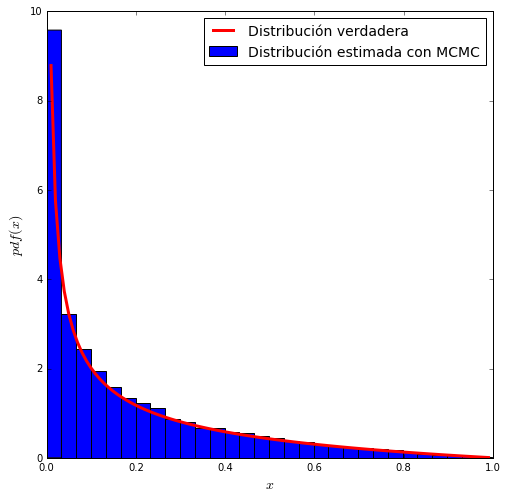

In [11]:
# distribución beta
func = stats.beta(0.4, 2)
samples = metropolis(func=func, steps=100000)
x = np.linspace(0.01, .99, 100)
y = func.pdf(x)
plt.figure(figsize=(8,8))
plt.xlim(0, 1)
plt.plot(x, y, 'r-', lw=3, label='Distribución verdadera')
plt.hist(samples, bins=30, normed=True, label='Distribución estimada con MCMC')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$pdf(x)$', fontsize=14)
plt.legend(fontsize=14)
plt.show()

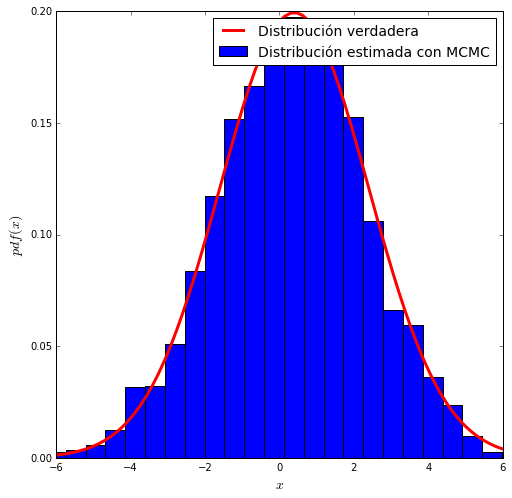

In [12]:
# distribución normal
func = stats.norm(0.4, 2)
samples = metropolis(func=func)
x = np.linspace(-6, 10, 100)
y = func.pdf(x)
plt.figure(figsize=(8,8))
plt.xlim(-6, 6)
plt.plot(x, y, 'r-', lw=3, label='Distribución verdadera')
plt.hist(samples, bins=30, normed=True, label='Distribución estimada con MCMC')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$pdf(x)$', fontsize=14)
plt.legend(fontsize=14)
plt.show()

como vemos, las [distribuciones](http://relopezbriega.github.io/blog/2016/06/29/distribuciones-de-probabilidad-con-python/) estimadas utilizando [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) se acercan bastante a las [distribuciones](http://relopezbriega.github.io/blog/2016/06/29/distribuciones-de-probabilidad-con-python/) reales.

### Otros métodos MCMC

Además del [algoritmo Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) existen otros algoritmos de muestreo que utilizan los métodos [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo). Algunos de ellos son:

* **[Muestreo de Gibbs](https://es.wikipedia.org/wiki/Muestreo_de_Gibbs)**, el cual es un caso especial del [algoritmo Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm).

* **[Monte-Carlo Hamiltoniano o híbrido](https://en.wikipedia.org/wiki/Hybrid_Monte_Carlo)**, el cual reduce la correlación entre los sucesivos estados de muestreo usando una evolución [Hamiltoniana](https://es.wikipedia.org/wiki/Mec%C3%A1nica_hamiltoniana). 

* **[Muestreo de rebanada o Slice sampler](https://en.wikipedia.org/wiki/Slice_sampling)**, este método se basa en la observación de que para muestrear una [variable aleatoria](https://es.wikipedia.org/wiki/Variable_aleatoria) se pueden tomar muestras en forma uniforme de la región debajo del gráfico de su [función de densidad](https://es.wikipedia.org/wiki/Funci%C3%B3n_de_densidad_de_probabilidad).

* **[NUTS o No U turn sampler](https://arxiv.org/abs/1111.4246)**, el cual es una extensión del algoritmo [híbrido de Monte-Carlo](https://en.wikipedia.org/wiki/Hybrid_Monte_Carlo) que logra incluso mayor eficiencia.
